# 1. Einleitung
Seit Beginn der Wetteraufzeichnungen haben sich unsere Städte und Siedlungen dramatisch verändert. Die Urbanisierung hat zu einer Vielzahl von Veränderungen geführt, darunter Bevölkerungswachstum, Infrastruktur, Landnutzung und Umweltverschmutzung. Gleichzeitig sind die globalen Temperaturen gestiegen, und der Klimawandel ist zu einem drängenden Problem geworden.

In dieser Studie wird der mögliche Zusammenhang zwischen der Urbanisierung und der geologischen Lage von Wetterstationen und den steigenden Temperaturen untersucht. Die Forschungsfragen lauten:

- Hat die zunehmende Urbanisierung dazu beigetragen, dass die Temperaturmessungen an Wetterstationen beeinflusst wurden?
- Hat die Auswahl der Wetterstationen und deren geologische Lage einen Einfluss auf die Durchschnittstemperatur in Deutschland?

Um diese Fragen zu beantworten, werden historische Wetterdaten analysiert und die Entwicklung von Wetterstationen in städtischen Gebieten im Vergleich zu ländlichen Regionen betrachtet.

# 2. Definition wichtiger Funktionen
In diesem Abschnitt werden funktionen definiert, die im späteren verlauf für die Analyse zum Einsatz kommen. Dies verbessert die Übersichtlichkeit der Analyse.

In [75]:
import os
import zipfile
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from tqdm import tqdm
import plotly.io as pio
import seaborn as sns
import numpy as np
import matplotlib.image as mpimg
from sklearn.linear_model import LinearRegression

In [28]:
def get_station_info(file_path):
    colspecs_head = [
        (0, 11),    # Stations_id
        (12, 21),   # von_datum
        (22, 31),   # bis_datum
        (32, 45),   # Stationshoehe
        (46, 55),   # geoBreite
        (56, 65),   # geoLaenge
        (66, 78),   # Stationsname
        (79, 89)    # Bundesland (Assuming it spans till the end)
    ]

    colspecs = [
        (0, 5),     # Stations_id
        (6, 14),    # von_datum
        (15, 23),   # bis_datum
        (24, 38),   # Stationshoehe
        (39, 50),   # geoBreite
        (51, 60),   # geoLaenge
        (61, 141),  # Stationsname
        (142, None) # Bundesland (Assuming it spans till the end)
    ]
    columns = pd.read_fwf(file_path, colspecs=colspecs_head, encoding='latin1').columns

    data = pd.read_fwf(file_path, colspecs=colspecs, encoding='latin1')
    data = data.iloc[1:]
    data.columns = columns
    data = to_float(data, columns=['geoBreite', 'geoLaenge'])
    data = to_int(data, columns=['Stations_id', 'Stationshoehe'])
    data = convert_date(data, 'von_datum', format='%Y%m%d')
    data = convert_date(data, 'bis_datum', format='%Y%m%d')
    data = data[pd.to_datetime(data['von_datum'], format='%d.%m.%Y') >= pd.to_datetime('01.01.1940', format='%d.%m.%Y')]
    return data

def read_txt_from_zip(zip_file, load_option):
    with zipfile.ZipFile(zip_file, 'r') as zf:
        txt_filename = [f for f in zf.namelist() if f.endswith('.txt') and 'produkt' in f]
        with zf.open(txt_filename[0]) as txt_file:
            df = pd.read_csv(txt_file, sep=';', engine="pyarrow")
    df = df.drop(columns=['eor', 'QN_9'])   
    df = df[df['TT_TU']>=-30]  
    df.rename(columns={'STATIONS_ID': 'Stations_id', 'MESS_DATUM': 'Datum_Messung', 'RF_TU': 'Feuchte_in_%', 'TT_TU': 'Lufttemperatur_in_°C',}, inplace=True)
    df = convert_date(df, 'Datum_Messung')
    if load_option == 'trimmed':
        df = trim_data_to_3h_average(df)
    df = to_int(df, columns=['Stations_id'])
    df = split_year_data(df)
    return df

def read_txt(folder_path, trim_data):
    txt_filename = [f for f in os.listdir(folder_path) if f.endswith('.txt') and 'produkt' in f]
    txt_filename_path = os.path.join(folder_path, txt_filename[0])
    df = pd.read_csv(txt_filename_path, sep=';', engine="pyarrow")
    df = df.drop(columns=['eor', 'QN_9'])
    df = df[df['TT_TU']>=-30 and df['TT_TU']<=50]
    df.rename(columns={'STATIONS_ID': 'Stations_id', 'MESS_DATUM': 'Datum_Messung', 'RF_TU': 'Feuchte_in_%', 'TT_TU': 'Lufttemperatur_in_°C',}, inplace=True)
    df = convert_date(df, 'Datum_Messung')
    if trim_data:
        df = trim_data_to_3h_average(df)
    df = to_int(df, columns=['Stations_id'])
    df = split_year_data(df)
    return df

def trim_data_to_3h_average(df):
    df_resampled = df.set_index('Datum_Messung').resample('3H', label='right')['Lufttemperatur_in_°C', 'Feuchte_in_%'].mean()
    df = df.drop(columns=['Lufttemperatur_in_°C', 'Feuchte_in_%'])
    merged_df = pd.merge(df_resampled, df, left_index=True, right_on='Datum_Messung', how='left')
    merged_df = merged_df.dropna()
    return merged_df

def convert_date(df, column, format='%Y%m%d%H'):
    df[column] = pd.to_datetime(df[column], format=format)
    return df

def split_year_data(df):
    df['Jahr'] = df['Datum_Messung'].dt.year
    df['Monat'] = df['Datum_Messung'].dt.month
    df['Stunde'] = df['Datum_Messung'].dt.hour
    df['Tag_im_Jahr'] = df['Datum_Messung'].dt.dayofyear
    return df

def load_temperature_data(folder_path, load_option):
    dfs = []
    folders = [folder for folder in os.listdir(folder_path) if folder.endswith('.zip')]
    for file_name in tqdm(folders):
        zip_file_path = os.path.join(folder_path, file_name)
        dfs.append(read_txt_from_zip(zip_file_path, load_option))
    final_df = pd.concat(dfs, ignore_index=True)
    return final_df

def load_file(folder_path, file_name):
    if file_name.endswith('.zip'):
        zip_file_path = os.path.join(folder_path, file_name)
        return read_txt_from_zip(zip_file_path)
    return None

def get_operation_timespan(df):
    df['Messzeitraum'] = (pd.to_datetime(df['bis_datum'], format='%d.%m.%Y') - pd.to_datetime(df['von_datum'], format='%d.%m.%Y')) / pd.Timedelta(days=365.25)
    return df

def to_int(df, columns=[]):
    for col in columns:
        df[col] = df[col].astype(int)
    return df

def to_float(df, columns=[]):
    for col in columns:
        df[col] = df[col].astype(float)
    return df

def plot_map_heatmap(df):
    plot = go.Densitymapbox(
            lat=df['geoBreite'],
            lon=df['geoLaenge'],
            z=df['geoBreite'],
            radius=20,
            colorscale='Viridis',
            colorbar=dict(
                title='Colorbar Title'
            ),
        )

    return plot

def plot_map(df, year):
    filtered_df = df[(pd.to_datetime(df['von_datum'], format='%d.%m.%Y') <= pd.to_datetime(year, format='%Y')) & 
                     (pd.to_datetime(df['bis_datum'], format='%d.%m.%Y') >= pd.to_datetime(year, format='%Y'))]
    test = (pd.to_datetime(year, format='%Y') - pd.to_datetime(filtered_df['von_datum'], format='%d.%m.%Y')) / pd.Timedelta(days=365.25)
    plot = go.Scattermapbox(
            lat=filtered_df['geoBreite'],
            lon=filtered_df['geoLaenge'],
            mode='markers',
            marker=dict(size=9, color=test),
            text=filtered_df['Stationsname'] + '<br>' +
                'Latitude: ' + filtered_df['geoBreite'].astype(str) + '<br>' +
                'Longitude: ' + filtered_df['geoLaenge'].astype(str),
            hoverinfo='text',
            name='Wetterstationen'
        )

    return plot


def plot_lat_location_histogram(df, year):
    filtered_df = df[(pd.to_datetime(df['von_datum'], format='%d.%m.%Y') <= pd.to_datetime(year, format='%Y')) & 
                     (pd.to_datetime(df['bis_datum'], format='%d.%m.%Y') >= pd.to_datetime(year, format='%Y'))]
    plot = go.Histogram(y=filtered_df['geoBreite'], marker_color='grey', opacity=0.7, name='Häufigkeit')
    return plot

def plot_lon_location_histogram(df, year):
    filtered_df = df[(pd.to_datetime(df['von_datum'], format='%d.%m.%Y') <= pd.to_datetime(year, format='%Y')) & 
                     (pd.to_datetime(df['bis_datum'], format='%d.%m.%Y') >= pd.to_datetime(year, format='%Y'))]
    plot = go.Histogram(x=filtered_df['geoLaenge'], marker_color='grey', opacity=0.7, name='Häufigkeit')
    return plot

def plot_year(year):
    plot = go.Indicator(
        mode="number",
        value=year,
        title="Year",
        number={'font': {'size': 35}},
        title_font={'size': 30})
    return plot

def plot_map_subplot(df):
    fig = make_subplots(rows=2, cols=2, 
                        subplot_titles=("Map", "Histogram", "Histogram"), 
                        specs=[[{"type": "scattermapbox"}, {"type": "histogram"}],
                               [{"type": "histogram"}, {"type": 'indicator'}]],
                        column_widths=[0.8, 0.3],
                        row_heights=[0.8, 0.3],
                        vertical_spacing=0.05,
                        horizontal_spacing=0.05,
                        )
    frames = []
    start_year = 1945
    end_year = 2024
    for year in tqdm(range(start_year, end_year + 1)):
        frames.append(go.Frame(data=[plot_map(df, year),
                                     plot_lat_location_histogram(df, year),
                                     plot_lon_location_histogram(df, year),
                                     plot_year(year)], 
                                name=str(year)))

    fig.frames = frames

    fig.add_trace(plot_map(df, start_year), row=1, col=1)
    fig.add_trace(plot_lat_location_histogram(df, start_year), row=1, col=2)
    fig.add_trace(plot_lon_location_histogram(df, start_year), row=2, col=1)
    fig.add_trace(plot_year(start_year), row=2, col=2)

    fig.update_layout(mapbox1=dict(zoom=4.8, style='open-street-map', center=dict(lat=51.3, lon= 10.12),),
                      updatemenus=[{
                                    "buttons": [
                                        {
                                            "args": [None, {"frame": {"duration": 200, "redraw": True}, "fromcurrent": True, "transition": {"duration": 200}}],
                                            "label": "Play",
                                            "method": "animate",
                                        },
                                        {
                                            "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate", "transition": {"duration": 0}}],
                                            "label": "Pause",
                                            "method": "animate",
                                        },
                                    ],
                                    "direction": "left",
                                    "pad": {"r": 10, "t": 87},
                                    "showactive": False,
                                    "type": "buttons",
                                    "x": 0.1,
                                    "xanchor": "right",
                                    "y": 0,
                                    "yanchor": "top"
                                }],
                                sliders=[{
                                    "active": 0,
                                    "yanchor": "top",
                                    "xanchor": "left",
                                    "currentvalue": {
                                        "font": {"size": 20},
                                        "prefix": "Year:",
                                        "visible": True,
                                        "xanchor": "right"
                                    },
                                    "transition": {"duration": 300, "easing": "cubic-in-out"},
                                    "pad": {"b": 10, "t": 50},
                                    "len": 0.9,
                                    "x": 0.1,
                                    "y": 0,
                                    "steps": [{"args": [[str(frame.name)], {"frame": {"duration": 300, "redraw": True}, "mode": "immediate", "transition": {"duration": 300}}],"label": str(frame.name), "method": "animate"} for frame in fig.frames]
                                }]
            	        )

    fig.update_layout(height=1000, width=1500, title_text="Combined Plot with Subplots")

    fig.update_xaxes(title_text="Häufigkeit", row=1, col=2)
    fig.update_yaxes(title_text="Latitude", range=[46.5,55.7], row=1, col=2)
    
    fig.update_xaxes(title_text="Longitude", range=[-1,21], row=2, col=1)
    fig.update_yaxes(title_text="Häufigkeit", row=2, col=1)
    fig.update_yaxes(autorange="reversed", row=2, col=1)

    pio.write_html(fig, "plotly_animation.html")

    fig.show()

def plot_station_histogram(df):
    df['von_datum'] = pd.to_datetime(df['von_datum'], format='%d.%m.%Y')
    df['bis_datum'] = pd.to_datetime(df['bis_datum'], format='%d.%m.%Y')

    start_date = df['von_datum'].min()
    end_date = df['bis_datum'].max()
    timeline = pd.date_range(start=start_date, end=end_date, freq='Q')

    operating_stations_count = []
    for date in timeline:
        count = ((df['von_datum'] <= date) & (df['bis_datum'] >= date)).sum()
        operating_stations_count.append(count)

    plt.figure(figsize=(10, 4))
    plt.bar(timeline, operating_stations_count, width=100)
    plt.title('Number of Operating Weather Stations Over Time')
    plt.xlabel('Timeline')
    plt.ylabel('Number of Operating Stations')
    plt.tight_layout()
    plt.show()
    
def filter_by_min_operation_time(df, min_operation_time):
    ids_to_drop = []
    for id, group_data in tqdm(df.groupby('Stations_id')):
        if group_data.Jahr.iat[-1] - group_data.Jahr.iat[0] <= min_operation_time:
            ids_to_drop.append(id)
    df = df[~df['Stations_id'].isin(ids_to_drop)]
    return df

def get_daily_average_temperature_day_and_night(df):
    df = df[['Datum_Messung', 'Stunde', 'Lufttemperatur_in_°C']]
    df = df.dropna(subset=['Lufttemperatur_in_°C'])
    day_mask = (df['Stunde'] >= 8) & (df['Stunde'] < 20)
    night_mask = ~day_mask
    df['Tag'] = df.loc[day_mask, 'Lufttemperatur_in_°C']
    df['Nacht'] = df.loc[night_mask, 'Lufttemperatur_in_°C']
    result_df = df.groupby(df['Datum_Messung'].dt.date).agg({
        'Tag': 'mean',
        'Nacht': 'mean'
    }).reset_index()
    result_df['Datum_Messung'] = pd.to_datetime(result_df['Datum_Messung'])
    result_df['Jahr'] = result_df['Datum_Messung'].dt.year
    result_df['Monat'] = result_df['Datum_Messung'].dt.month
    result_df['Tag_im_Jahr'] = result_df['Datum_Messung'].dt.dayofyear
    result_df.rename(columns={'Datum_Messung': 'Datum', 'Tag': 'Durchschnitt_Tag', 'Nacht': 'Durchschnitt_Nacht'}, inplace=True)
    result_df = result_df.dropna()
    return result_df

def get_anual_average_temperature_day_and_night(df):
    df = df[['Datum_Messung', 'Jahr', 'Monat', 'Stunde', 'Lufttemperatur_in_°C']]
    
    df = df.dropna(subset=['Lufttemperatur_in_°C'])
    day_mask = (df['Stunde'] >= 8) & (df['Stunde'] < 20)
    night_mask = ~day_mask
    df['Durchschnitt_Tag'] = df.loc[day_mask, 'Lufttemperatur_in_°C']
    df['Durchschnitt_Nacht'] = df.loc[night_mask, 'Lufttemperatur_in_°C']
    df['Durchschnitt'] = df['Lufttemperatur_in_°C']
    
    result_df = df.groupby(pd.to_datetime(df['Jahr'], format='%Y').dt.year).agg({
        'Durchschnitt_Tag': 'mean',
        'Durchschnitt_Nacht': 'mean',
        'Durchschnitt': 'mean'
    }).reset_index()
    
    result_df = result_df.dropna()
    
    return result_df

def get_monthly_average_temperature_day_and_night(df):
    df = df[['Datum_Messung', 'Jahr', 'Monat', 'Stunde', 'Lufttemperatur_in_°C']]
    df = df.dropna(subset=['Lufttemperatur_in_°C'])
    day_mask = (df['Stunde'] >= 8) & (df['Stunde'] < 20)
    night_mask = ~day_mask
    df['Durchschnitt_Tag'] = df.loc[day_mask, 'Lufttemperatur_in_°C']
    df['Durchschnitt_Nacht'] = df.loc[night_mask, 'Lufttemperatur_in_°C']
    df['Durchschnitt'] = df['Lufttemperatur_in_°C']
    result_df = df.groupby([pd.to_datetime(df['Jahr'], format='%Y').dt.year, pd.to_datetime(df['Monat'], format='%m').dt.month]).agg({
        'Durchschnitt_Tag': 'mean',
        'Durchschnitt_Nacht': 'mean',
        'Durchschnitt': 'mean'
    }).reset_index()
    
    result_df = result_df.dropna() 
    return result_df

def calc_temp_change_for_station(df):
    fitted_lines_day = np.zeros((12, 2))
    fitted_lines_night = np.zeros((12, 2))
    fitted_lines = np.zeros((12, 2))
    for month, group_data in df.groupby('Monat'):
        X = group_data['Jahr'].values.reshape(-1, 1)
        y1 = group_data['Durchschnitt_Tag'].values
        y2 = group_data['Durchschnitt_Nacht'].values
        y3 = group_data['Durchschnitt'].values
        model1 = LinearRegression()
        model1.fit(X, y1)
        model2 = LinearRegression()
        model2.fit(X, y2)
        model3 = LinearRegression()
        model3.fit(X, y3)
        fitted_lines_day[month-1][0] = model1.coef_[0] 
        fitted_lines_day[month-1][1] = model1.intercept_
        fitted_lines_night[month-1][0] = model2.coef_[0] 
        fitted_lines_night[month-1][1] = model2.intercept_
        fitted_lines[month-1][0] = model3.coef_[0] 
        fitted_lines[month-1][1] = model3.intercept_
    max_slope_day = max(fitted_lines_day[:,0].max(), abs(fitted_lines_day[:,0].min()))
    max_slope_night = max(fitted_lines_night[:,0].max(), abs(fitted_lines_night[:,0].min()))
    max_slope = max(fitted_lines[:,0].max(), abs(fitted_lines[:,0].min()))
    average_slope_day = np.average(fitted_lines_day[:,0])
    average_slope_night = np.average(fitted_lines_night[:,0])
    average_slope = np.average(fitted_lines[:,0])
    return max_slope_day, max_slope_night, max_slope, average_slope_day, average_slope_night, average_slope

def get_temp_change_data(monthly_average):
    data = {'max_slope_day': [0,0], 'max_slope_night': [0,0], 'average_slope_day': [0,0], 'average_slope_night': [0,0]}
    max_slope_day, max_slope_night, average_slope_day, average_slope_night = calc_temp_change_for_station(monthly_average)
    data['max_slope_day'] = [max_slope_day, id] if data['max_slope_day'][0] < max_slope_day else data['max_slope_day']
    data['max_slope_night'] = [max_slope_night, id] if data['max_slope_night'][0] < max_slope_night else data['max_slope_night']
    data['average_slope_day'] = [average_slope_day, id] if data['average_slope_day'][0] < average_slope_day else data['average_slope_day']
    data['average_slope_night'] = [average_slope_night, id] if data['average_slope_night'][0] < average_slope_night else data['average_slope_night']

def get_monthly_average_and_temp_change(temp_data):
    daily_average_df = pd.DataFrame()
    monthly_average_df = pd.DataFrame()
    anual_average_df = pd.DataFrame()
    for id, group_data in tqdm(temp_data.groupby('Stations_id')): 
        daily_average = get_daily_average_temperature_day_and_night(group_data)
        daily_average['Stations_id'] = id
        daily_average_df = pd.concat([daily_average_df, daily_average], ignore_index=True)
        monthly_average = get_monthly_average_temperature_day_and_night(group_data)
        monthly_average['Stations_id'] = id
        monthly_average_df = pd.concat([monthly_average_df, monthly_average], ignore_index=True)
        anual_average = get_anual_average_temperature_day_and_night(group_data)
        anual_average['Stations_id'] = id
        anual_average_df = pd.concat([anual_average_df, anual_average], ignore_index=True)
    return daily_average_df, monthly_average_df, anual_average_df

def calc_trend_line_monthly(df, column='Durchschnitt'):
    temp_increase = {}
    for month, group_data in df.groupby('Monat'):
        X = group_data['Jahr'].values.reshape(-1, 1)
        y = group_data[column].values
        model = LinearRegression()
        model.fit(X, y)
        max_year = group_data['Jahr'].max()
        min_year = group_data['Jahr'].min()
        slope = model.coef_[0]
        intercept = model.intercept_
        temp_increase[month] = (slope * max_year + intercept) - (slope * min_year + intercept)     
    return temp_increase

def plot_temperature_over_year_and_month(df_monthly_average, df_daily_average, plot_column='Durchschnitt'):
    plot_trend = True
    fig = go.Figure(data=[go.Scatter3d(
        x=df_monthly_average['Monat'],
        y=df_monthly_average['Jahr'],
        z=df_monthly_average[plot_column],
        mode='markers',
        marker=dict(
            size=3,
            color=df_monthly_average[plot_column],
            colorscale='Viridis',
            opacity=0.8
        ),
        name='Durchschn. Temp'
    )])
    if plot_trend:
        fitted_lines = {}
        for month, group_data in df_monthly_average.groupby('Monat'):
            X = group_data['Jahr'].values.reshape(-1, 1)
            y = group_data[plot_column].values
            model = LinearRegression()
            model.fit(X, y)
            fitted_lines[month] = (model.coef_[0], model.intercept_)
        for month, (slope, intercept) in fitted_lines.items():
            color_scale = 'Reds' if slope > 0 else 'Greens'
            month_data = df_daily_average[df_daily_average['Tag_im_Jahr'] == month]
            min_year = month_data['Jahr'].min()
            max_year = month_data['Jahr'].max()
            if slope < 0:
                fig.add_trace(go.Scatter3d(
                    x=[month] * 2,
                    y=[min_year, max_year],
                    z=[slope * min_year + intercept, slope * max_year + intercept],
                    mode='lines',
                    line=dict(colorscale=color_scale, width=4, cmin=-0.02, cmax=0, color=[slope, slope], reversescale=True),
                    name='Monat '+str(month)+'('+str("{:.2f}".format((slope * max_year + intercept) - (slope * min_year + intercept)))+'°C)'
                ))
            elif slope > 0:
                fig.add_trace(go.Scatter3d(
                    x=[month] * 2,
                    y=[min_year, max_year],
                    z=[slope * min_year + intercept, slope * max_year + intercept],
                    mode='lines',
                    line=dict(colorscale=color_scale, width=4, cmin=-0, cmax=0.02, color=[slope, slope]),
                    name='Monat '+str(month)+'(+'+str("{:.2f}".format((slope * max_year + intercept) - (slope * min_year + intercept)))+'°C)'
                ))

    fig.update_layout(
        title=plot_column,
        scene=dict(
                                    xaxis_title='Monat',
                                    yaxis_title='Jahr',
                                    zaxis_title='Temperatur'
                                ), 
                    margin=dict(l=0, r=0, t=50, b=0),
                    width=1000, height=500, scene_camera=dict(eye=dict(x=1.5, y=1.5, z=0.2)))

    fig.show()

def merge_temp_with_location(temp, station_info):
    station_info = station_info[['Stations_id', 'geoBreite', 'geoLaenge', 'Stationshoehe', 'Stationsname', 'Bundesland']]
    df_merged = pd.merge(temp, station_info, on='Stations_id', how='outer')
    return df_merged.dropna()

# 3. Laden und Bearbeiten/Transformieren der Daten
Die Analyse bezieht Daten aus zwei Datensätzen. Der erste Datensatz (Stationsinfos) umfasst spezifische Daten der einzelnen Wetterstationen, wie zum Beispiel die Position, den Operationszeitraum und die ID. Der zweite Datensatz (Wetterdaten) beinhaltet die aufgezeichneten Wetterdaten der einzelnen Stationen und dient zur Ermittlung der historischen Temperaturdaten. Jede Wetterstation hat einen unterschiedlichen Operationszeitraum und demnach auch eine unterschiedlich lange Historie an Daten.

In [6]:
station_info_path = r'Daten\TU_Stundenwerte_Beschreibung_Stationen.txt'
temperature_path = r'Daten\temperatur'

Da es sich bei den Wetterdaten um einen sehr großen Datensatz handelt, wird hier empfohlen, die Load-Option 'trimmed' auszuwählen. Mit dieser Option wird der Datensatz von stündlich auf einen durchschnittlichen Wert alle 3 Stunden reduziert. Um die Ladezeit zu verringern, wurde bereits eine entsprechende Parquet-Datei generiert. Ist die Parquet-Datei im Datensatz nicht vorhanden, so werden die Daten normal geladen und automatisch eine Parquet-Datei erstellt. Die Wetterdaten liegen in stationsspezifischen .zip-Ordnern zur Verfügung und müssen demnach über eine for-Schleife einzeln eingelesen und am Schluss zu einem gesamten pandas Dataframe zusammengefasst werden. Auch hier wird nachträglich noch jede Spalte zu den entsprechenden Datentypen transformiert. Das genaue Vorgehen wird in den Funktionen beschrieben.

Die Stationsinfos liegen in einem speziellen Format namens Fixed Width Format in einer .txt-Datei ab. Das bedeutet, dass die einzelnen Daten nicht wie üblich durch ein Komma oder eine Leertaste getrennt sind, sondern in der .txt-Datei bestimmte Abstände für die Formatierung eingehalten werden müssen. Diese Abstände sind in der Funktion get_station_info fest hinterlegt. Da beim Einlesen der Daten alle Spalten als Datentyp object von pandas behandelt werden, müssen diese anschließend noch transformiert werden. Dafür stehen Funktionen zur Verfügung, die die gewünschten Spalten beispielsweise zu float oder integer transformieren.

In [13]:
# Zwischen 'raw' und 'trimmed' auswählen. ('raw' benötigt über 32 GB RAM)
load_option = 'trimmed'
# Laden der Wetterstantionen
station_info = get_station_info(station_info_path)
station_info = get_operation_timespan(station_info)
# Laden der Wetterdaten
if 'wetterdaten_'+load_option+'.parquet.gzip' in os.listdir(temperature_path) and load_option == 'raw':
    temp_data = pd.read_parquet(os.path.join(temperature_path, 'wetterdaten_'+load_option+'.parquet.gzip')) 
elif 'wetterdaten_'+load_option+'.parquet.gzip' in os.listdir(temperature_path) and load_option == 'trimmed':
    temp_data = pd.read_parquet(os.path.join(temperature_path, 'wetterdaten_'+load_option+'.parquet.gzip')) 
else: 
    temp_data = load_temperature_data(temperature_path, load_option)
    temp_data.to_parquet(os.path.join(temperature_path, 'wetterdaten_'+load_option+'.parquet.gzip'))

Für die Analyse werden zusätzlich neue Dataframes erzeugt, die bestimmte Berechnungen beinhalten. Wie diese Daten aufbereitet werden, wird dann an der entsprechenden Stelle beschrieben. Um das Preprocessing der Daten zu validieren, werden im Folgenden die Datentypen überprüft. Stimmt alles, so kann mit der Analyse begonnen werden.

In [14]:
temp_data.info()
station_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47354929 entries, 0 to 47354928
Data columns (total 8 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Lufttemperatur_in_°C  float64       
 1   Feuchte_in_%          float64       
 2   Stations_id           int32         
 3   Datum_Messung         datetime64[ns]
 4   Jahr                  int32         
 5   Monat                 int32         
 6   Stunde                int32         
 7   Tag_im_Jahr           int32         
dtypes: datetime64[ns](1), float64(2), int32(5)
memory usage: 1.9 GB
<class 'pandas.core.frame.DataFrame'>
Index: 662 entries, 1 to 663
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Stations_id    662 non-null    int32         
 1   von_datum      662 non-null    datetime64[ns]
 2   bis_datum      662 non-null    datetime64[ns]
 3   Stationshoehe  662 non-null    int32  

# 4. Analyse
In diesem Abschnitt findet die Analyse des Datensatz statt. Jede Analyse läuft für jeden Sektor nach dem gleichen Schema ab. Zuerst wird erklärt, was untersucht werden soll. Danach wird der Code dafür geschrieben und zuletzt werden die Teilergebnisse kommentiert. Die entsprechende Analyse und Bewertung der Ergebnisse finden in Kapitel 5. Zusammenfassung und Schlussfolgerung statt.

### 4.1 Übersicht Stationen

Zu Beginn wird eine Karte erzeugt, die die Positionen der einzelnen Wetterstationen über die Jahre hinweg anzeigt. Je älter eine Station wird, desto gelber wird ihre Farbe. Gleichzeitig wird ein Histogramm für Längen- und Breitengrad angezeigt, um die Verteilung der Stationen über Deutschland besser nachvollziehen zu können. Der Plot ist animiert. Die Animation kann entweder über die "Play" und "Pause" Tasten gesteuert werden oder durch den Schieberegler auf ein gewünschtes Jahr platziert werden. 

Danach zeigt ein Plot, wie sich die Anzahl der Stationen über die Jahre hinweg entwickelt hat. Zusätzlich wird auch die durchschnittliche Stationshöhe pro Jahr angegeben.

In [15]:
plot_map_subplot(station_info)

100%|██████████| 80/80 [00:01<00:00, 57.93it/s]


In [16]:
filtered_data = station_info[(station_info['von_datum'] >= pd.Timestamp('1945-01-01')) & 
                             (station_info['bis_datum'] <= pd.Timestamp('2024-04-01'))]

average_height_by_year = {'Durchschnittliche_Stationshoehe': [], 'Jahr': [], 'Anzahl_Stationen': []}


for year in range(1945, 2024):
    temp = pd.DataFrame([])
    temp_df = station_info[(station_info['von_datum'] <= pd.Timestamp(str(year)+'-01-01')) & 
                           (station_info['bis_datum'] >= pd.Timestamp(str(year)+'-12-31'))]
    average_height_by_year['Durchschnittliche_Stationshoehe'].append(temp_df['Stationshoehe'].mean())
    average_height_by_year['Jahr'].append(year)
    average_height_by_year['Anzahl_Stationen'].append(len(temp_df))
    
average_height_by_year = pd.DataFrame(average_height_by_year)

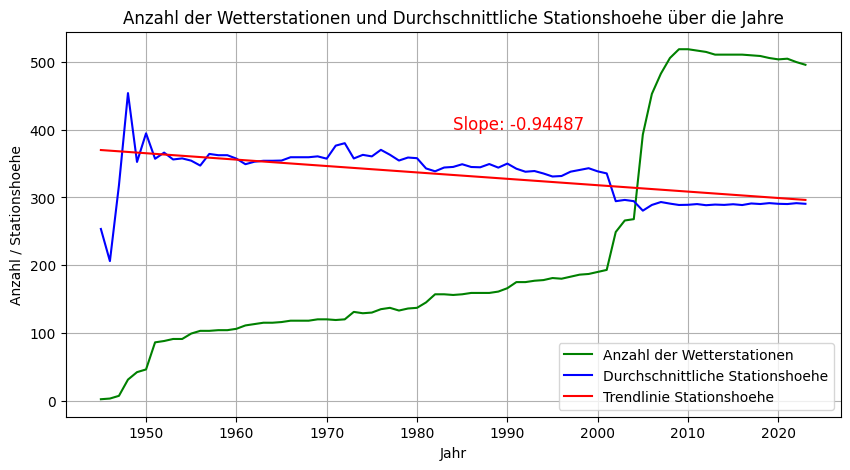

In [17]:
x = average_height_by_year['Jahr'].values.reshape(-1, 1)
y = average_height_by_year['Durchschnittliche_Stationshoehe'].values
trend = LinearRegression().fit(x, y)

plt.figure(figsize=(10, 5))

plt.plot(average_height_by_year['Jahr'], average_height_by_year['Anzahl_Stationen'], label='Anzahl der Wetterstationen', color='green')
plt.plot(average_height_by_year['Jahr'], average_height_by_year['Durchschnittliche_Stationshoehe'], label='Durchschnittliche Stationshoehe', color='blue')
plt.plot(x, trend.predict(x), color='red', label='Trendlinie Stationshoehe')
plt.text(x[int(len(x)/2)], 400, f'Slope: {trend.coef_[0]:.5f}', color='red', fontsize=12)
plt.title('Anzahl der Wetterstationen und Durchschnittliche Stationshoehe über die Jahre')
plt.xlabel('Jahr')
plt.ylabel('Anzahl / Stationshoehe')
plt.legend()
plt.grid(True)

plt.show()

In [20]:
big_drop = average_height_by_year[(average_height_by_year['Jahr'] >= 2001) & (average_height_by_year['Jahr'] <= 2002)]['Durchschnittliche_Stationshoehe'].values
decrease_of_average_height_in_percent = ((big_drop[0] - big_drop[1]) / big_drop[0]) * 100
print(f'Reduzierung der durchschnittlichen Stationshöhe im Jahr 2002: {decrease_of_average_height_in_percent} %')

Reduzierung der durchschnittlichen Stationshöhe im Jahr 2002: 12.225504860702854 %


Als Erstes fällt auf, dass die Anzahl der Wetterstationen um die Jahre 1950 und 2005 stark gewachsen ist. Seit 2010 nimmt die Anzahl an Wetterstationen langsam wieder ab. Weiterhin ist durch das Histogramm von Breiten- und Längengrad zu sehen, dass sich die Verteilung der Wetterstationen eher Richtung südliches Zentrum von Deutschland tendiert. Zudem ist interessant, dass mit der starken Zunahme an Wetterstationen um das Jahr 2002 die durchschnittliche Stationshöhe im Land um 12,2 Prozent gesunken ist.

### 4.2 Temperaturen

Als Nächstes wird die durchschnittliche Jahrestemperatur in Deutschland untersucht. Dabei wird unter anderem zwischen Tag und Nacht unterschieden. Damit soll gezeigt werden, wie sich der Temperaturverlauf im Jahresdurchschnitt über die Jahre entwickelt hat. Dafür wird zunächst mit den Wetterdaten ein Temperaturdurchschnitt für jeden Tag, jeden Monat und jedes Jahr berechnet und in drei verschiedene Dataframes abgespeichert. Der Jahresdurchschnitt wird dann einmal für tagsüber, für nachts und gesamt abgebildet. Die Berechnung kann ein paar Minuten dauern. Danach wird der ursprüngliche Dataframe der Temperaturdaten gelöscht, um Arbeitsspeicher freizugeben.

In [22]:
daily_average, monthly_average, anual_average = get_monthly_average_and_temp_change(temp_data)

100%|██████████| 627/627 [01:29<00:00,  7.04it/s]


In [23]:
temp_data = 0

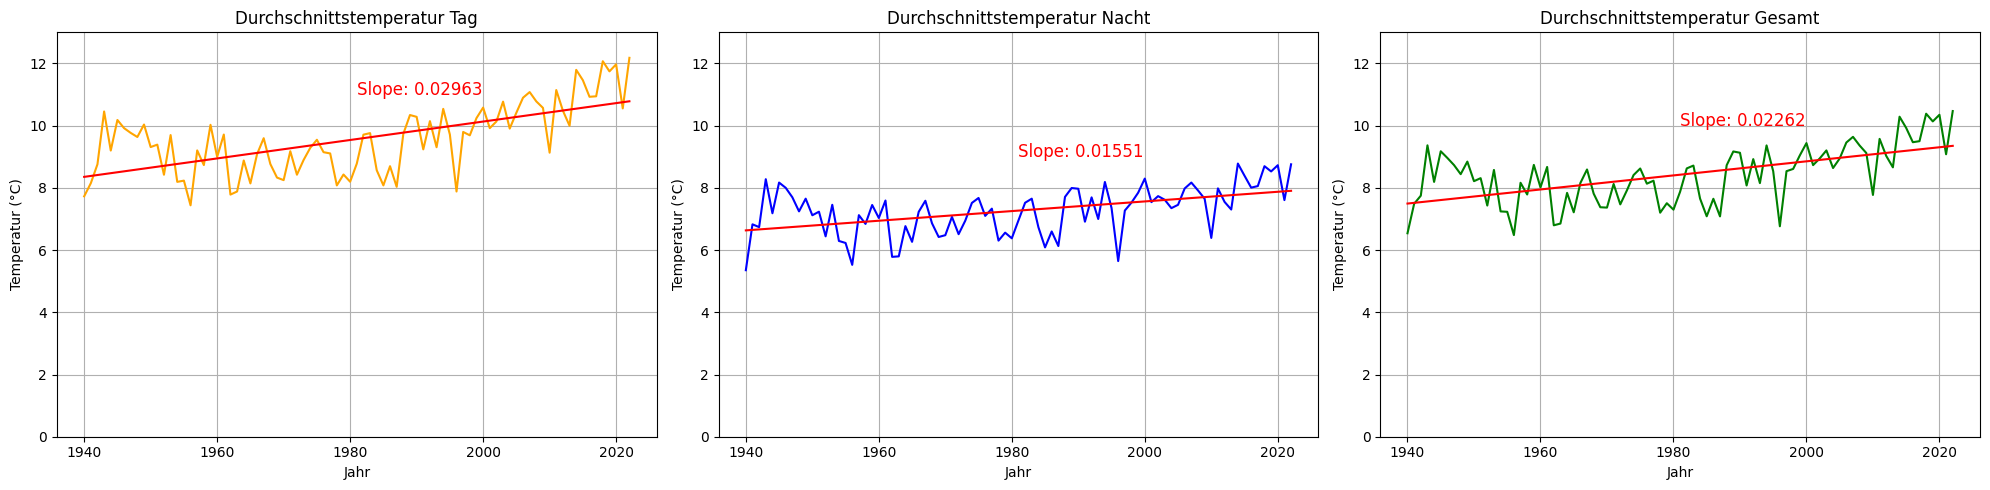

In [24]:
anual_average_overall = anual_average[['Jahr', 'Durchschnitt_Tag', 'Durchschnitt_Nacht', 'Durchschnitt']].groupby('Jahr').mean().reset_index()
anual_average_overall = anual_average_overall[anual_average_overall['Jahr']>=1940]
x = anual_average_overall['Jahr'].values.reshape(-1, 1)
y_day = anual_average_overall['Durchschnitt_Tag'].values
y_night = anual_average_overall['Durchschnitt_Nacht'].values
y = anual_average_overall['Durchschnitt'].values
trend_day = LinearRegression().fit(x, y_day)
trend_night = LinearRegression().fit(x, y_night)
trend = LinearRegression().fit(x, y)
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(anual_average_overall['Jahr'], anual_average_overall['Durchschnitt_Tag'], color='orange')
axs[0].plot(x, trend_day.predict(x), color='red', label='Trendlinie')
axs[0].text(x[int(len(x)/2)], 11, f'Slope: {trend_day.coef_[0]:.5f}', color='red', fontsize=12)
axs[0].set_title('Durchschnittstemperatur Tag')
axs[0].set_xlabel('Jahr')
axs[0].set_ylabel('Temperatur (°C)')
axs[0].set_ylim([0, 13])
axs[0].grid(True)

axs[1].plot(anual_average_overall['Jahr'], anual_average_overall['Durchschnitt_Nacht'], color='blue')
axs[1].plot(x, trend_night.predict(x), color='red', label='Trendlinie')
axs[1].text(x[int(len(x)/2)], 9, f'Slope: {trend_night.coef_[0]:.5f}', color='red', fontsize=12)
axs[1].set_title('Durchschnittstemperatur Nacht')
axs[1].set_xlabel('Jahr')
axs[1].set_ylabel('Temperatur (°C)')
axs[1].set_ylim([0, 13])
axs[1].grid(True)

axs[2].plot(anual_average_overall['Jahr'], anual_average_overall['Durchschnitt'], color='green')
axs[2].plot(x, trend.predict(x), color='red', label='Trendlinie')
axs[2].text(x[int(len(x)/2)], 10, f'Slope: {trend.coef_[0]:.5f}', color='red', fontsize=12)
axs[2].set_title('Durchschnittstemperatur Gesamt')
axs[2].set_xlabel('Jahr')
axs[2].set_ylabel('Temperatur (°C)')
axs[2].set_ylim([0, 13])
axs[2].grid(True)

plt.tight_layout()
plt.show()

Es fällt auf, dass die Durchschnittstemperatur in Deutschland insgesamt über die Jahre zunimmt. Interessant ist jedoch, dass die Jahresdurchschnittstemperatur tagsüber deutlich stärker angestiegen ist als die Temperatur nachts. Dies wird besonders durch die eingezeichnete Trendlinie deutlich. Die Trendlinie der durchschnittlichen Jahrestemperatur tagsüber hat nahezu eine doppelt so große Steigung wie die nächtliche Trendlinie.

Als Nächstes soll untersucht werden, welche Monate am stärksten zu der Erwärmung beitragen. Dazu werden die durchschnittlichen monatlichen Temperaturen über alle Wetterstationen über die Jahre in einem interaktiven 3D-Plot dargestellt. Danach wird für jeden Monat die Temperaturerhöhung seit Beginn der Wetteraufzeichnungen berechnet und in einem Säulendiagramm dargestellt.

In [29]:
monthly_average_overall = monthly_average[['Jahr', 'Monat', 'Durchschnitt_Tag', 'Durchschnitt_Nacht', 'Durchschnitt']].groupby(['Jahr', 'Monat']).mean().reset_index()
plot_temperature_over_year_and_month(monthly_average_overall, daily_average, plot_column='Durchschnitt_Tag')
plot_temperature_over_year_and_month(monthly_average_overall, daily_average, plot_column='Durchschnitt_Nacht')
plot_temperature_over_year_and_month(monthly_average_overall, daily_average, plot_column='Durchschnitt')

In den interaktiven 3D-Plots werden zusätzlich die Trendlinien mit dargestellt. Je roter eine Trendlinie ist, desto steiler positiv ist ihre Steigung. Je grüner eine Trendlinie ist, desto steiler negativ ist ihre Steigung. Es wird deutlich, dass die monatliche Durchschnittstemperatur der Wintermonate Januar, Februar, Oktober, November, Dezember mit Abstand am meisten zugenommen hat. Die Sommermonate Mai, Juni, Juli hingegen sind sogar kühler geworden.

In [30]:
monthly_average_temp_increase = calc_trend_line_monthly(monthly_average_overall, column='Durchschnitt')
monthly_average_temp_increase_day = calc_trend_line_monthly(monthly_average_overall, column='Durchschnitt_Tag')
monthly_average_temp_increase_night = calc_trend_line_monthly(monthly_average_overall, column='Durchschnitt_Nacht')

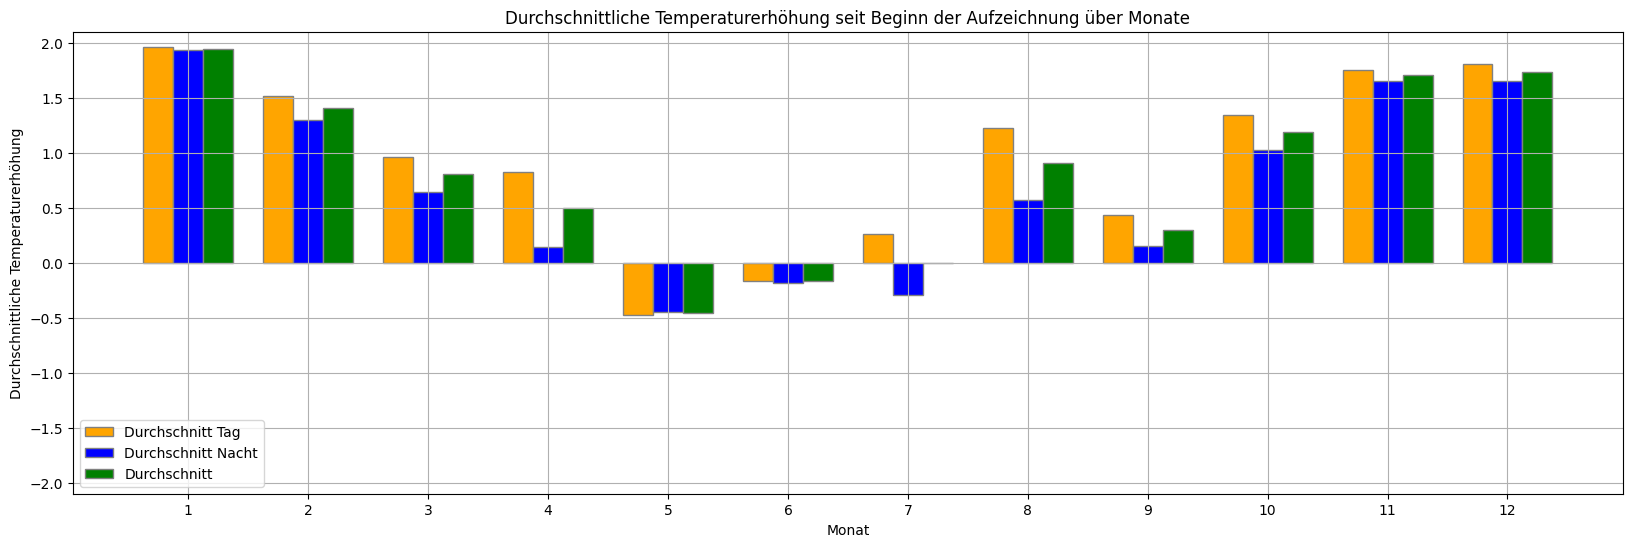

In [31]:
months = list(monthly_average_temp_increase_day.keys())
day_values = list(monthly_average_temp_increase_day.values())
night_values = list(monthly_average_temp_increase_night.values())
average_values = list(monthly_average_temp_increase.values())

bar_width = 0.25

r1 = range(len(months))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(20, 6))
plt.bar(r1, day_values, color='orange', width=bar_width, edgecolor='grey', label='Durchschnitt Tag')
plt.bar(r2, night_values, color='blue', width=bar_width, edgecolor='grey', label='Durchschnitt Nacht')
plt.bar(r3, average_values, color='green', width=bar_width, edgecolor='grey', label='Durchschnitt')
plt.xlabel('Monat')
plt.ylabel('Durchschnittliche Temperaturerhöhung')
plt.title('Durchschnittliche Temperaturerhöhung seit Beginn der Aufzeichnung')
plt.xticks([r + bar_width for r in range(len(months))], months)
plt.grid(True)
plt.ylim([-2.1, 2.1])
plt.legend()

plt.show()

Im Balkendiagramm wird diese Entwicklung noch deutlicher, zumal sich noch ein weiterer Effekt abzeichnet. In den Wintermonaten liegt die Änderung der monatlichen Durchschnittstemperatur zwischen Tag und Nacht weniger weit auseinander als in den Frühlings- und Spätsommer-/Herbstmonaten März, April, August, September. Besonders interessant verhält sich die Temperaturänderung im Monat Juli, wo die Tage tendenziell immer heißer werden, die Nächte jedoch immer kälter.

### 4.3 Geologische Lage

Im nächsten Abschnitt wird die geologische Lage der Stationen weiter untersucht. Dafür werden zunächst die Daten des heißesten Jahres seit Beginn der Wetteraufzeichnungen (2022) herangezogen. Zuerst wird ein Pairplot Zusammenhänge zwischen den einzelnen aufgezeichneten Werten darstellen, die anschließend von einer Korrelationsmatrix konkretisiert werden.

Zudem wird das Jahr 2022 auf einer Deutschlandkarte mit Datenpunkten dargestellt, deren Farbe von der Temperatur und deren Größe von der Stationshöhe abhängt. Dadurch soll die Nachvollziehbarkeit der Verteilung der Temperaturen und der Stationshöhen vereinfacht werden. Als weiterer Vergleich werden die Jahre 2000 und 2014 herangezogen, welche selbst zu ihrer Zeit als heißeste Jahre der Geschichte galten. Mit diesem Vergleich soll ermittelt werden, was sich von damals zu heute verändert hat und ob die Urbanisierung oder die geologische Lage für die Erhöhung der gemessenen Temperaturen verantwortlich gemacht werden kann.

In [32]:
monthly_average_of_year_2022 = monthly_average[monthly_average['Jahr']==2022]
monthly_average_of_year_2014 = monthly_average[monthly_average['Jahr']==2014]
monthly_average_of_year_2000 = monthly_average[monthly_average['Jahr']==2000]
monthly_average_of_year_2022_Stations_id = monthly_average_of_year_2022[['Monat', 'Durchschnitt_Tag', 'Durchschnitt_Nacht', 'Durchschnitt', 'Stations_id']].groupby(['Stations_id']).mean().reset_index()
monthly_average_of_year_2014_Stations_id = monthly_average_of_year_2014[['Monat', 'Durchschnitt_Tag', 'Durchschnitt_Nacht', 'Durchschnitt', 'Stations_id']].groupby(['Stations_id']).mean().reset_index()
monthly_average_of_year_2000_Stations_id = monthly_average_of_year_2000[['Monat', 'Durchschnitt_Tag', 'Durchschnitt_Nacht', 'Durchschnitt', 'Stations_id']].groupby(['Stations_id']).mean().reset_index()

In [33]:
monthly_average_of_year_2022_Stations_id_with_location = merge_temp_with_location(monthly_average_of_year_2022_Stations_id, station_info)
monthly_average_of_year_2014_Stations_id_with_location = merge_temp_with_location(monthly_average_of_year_2014_Stations_id, station_info)
monthly_average_of_year_2000_Stations_id_with_location = merge_temp_with_location(monthly_average_of_year_2000_Stations_id, station_info)

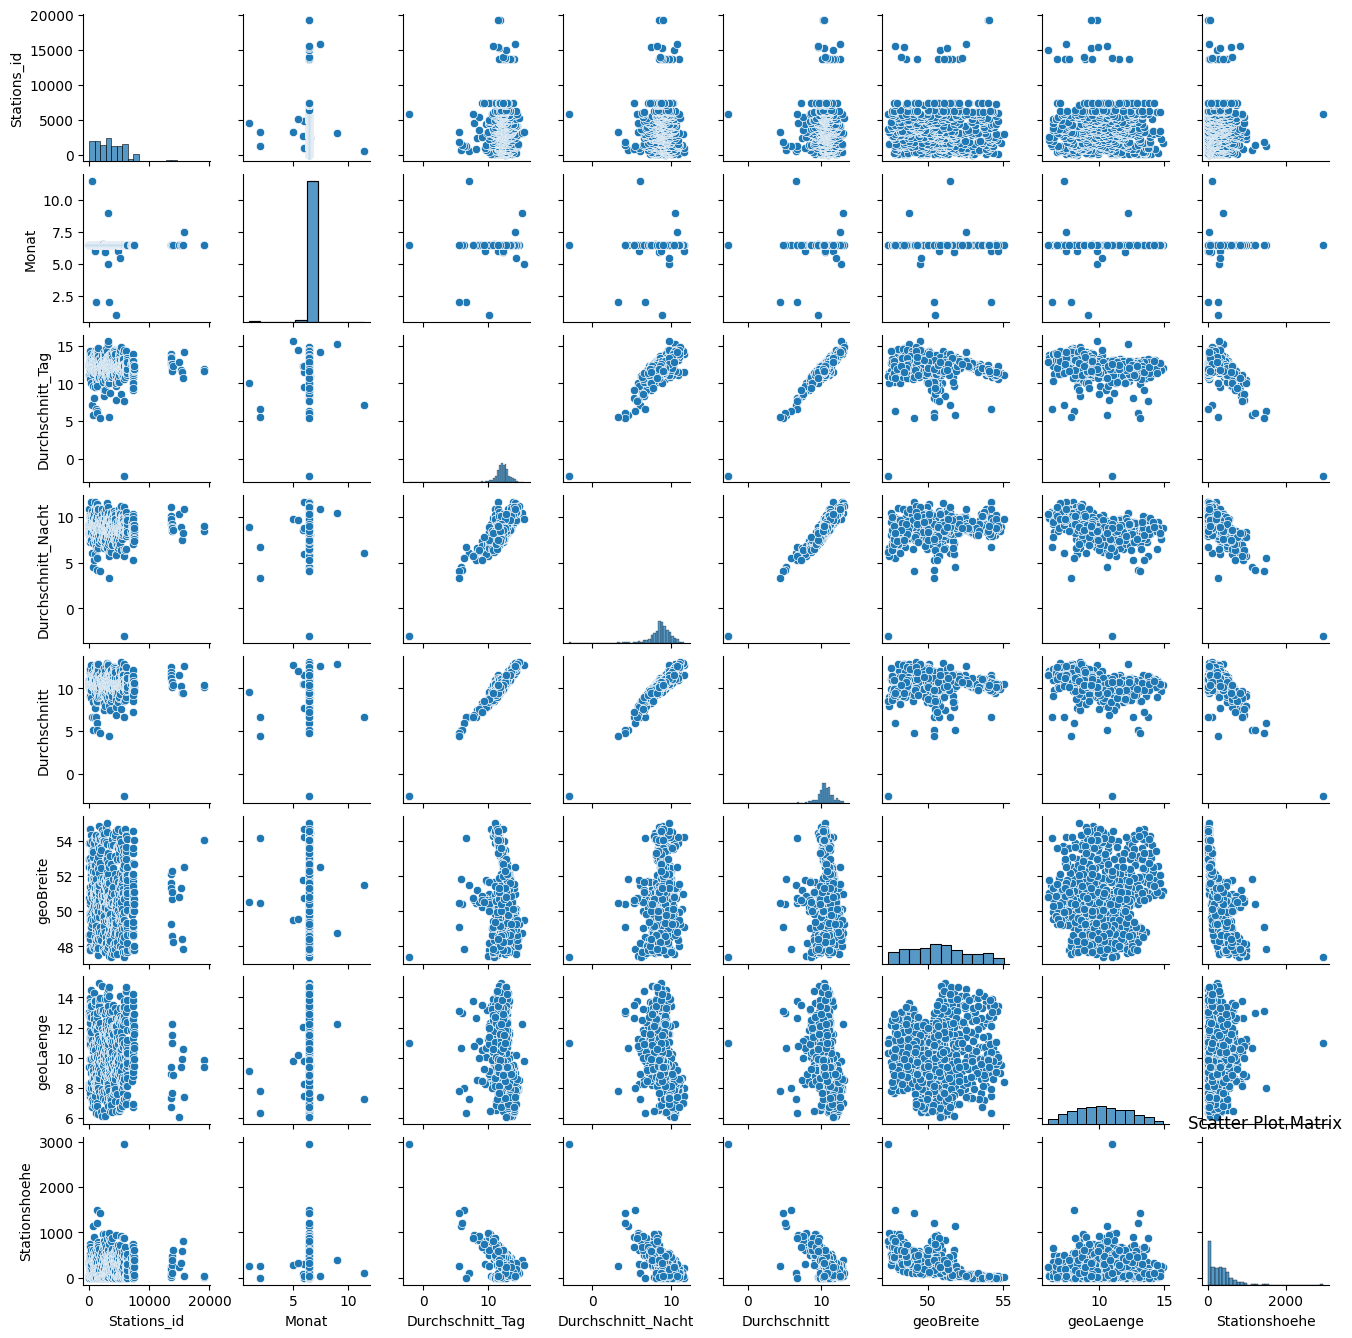

In [34]:
sns.pairplot(monthly_average_of_year_2022_Stations_id_with_location, height=1.7, aspect=1)
plt.title('Scatter Plot Matrix')
plt.show()

Mit Hilfe des Pairplots lassen sich gleich mehrere Zusammenhänge darstellen und Erkenntnisse gewinnen. Zuerst fällt auf, dass die Werte für Monat hin und wieder vom Wert 6,5 abweichen. Der Wert 6,5 ist der Berechnung der durchschnittlichen Temperaturen der einzelnen Stationen geschuldet. Operiert eine Station alle 12 Monate, so erhält sie einen Durchschnittswert von 6,5. Weicht der Wert davon ab, so weiß man, dass die Station nicht in jedem Monat Messdaten aufgezeichnet hat. Dadurch lassen sich Stationen aussortieren, die die Durchschnittstemperatur verfälschen würden. Weiterhin fällt auf, dass es eine Station gibt, die eine Stationshöhe von knapp 3000 m hat. Um den Einfluss solcher Ausreißer zu vermeiden, werden deshalb im Folgenden nur Stationen unter 800 m berücksichtigt.

In [47]:
monthly_average_of_year_2022_Stations_id_with_location_filtered = monthly_average_of_year_2022_Stations_id_with_location[
                        monthly_average_of_year_2022_Stations_id_with_location['Stationshoehe'] <= 800]
monthly_average_of_year_2022_Stations_id_with_location_filtered = monthly_average_of_year_2022_Stations_id_with_location_filtered[
                        monthly_average_of_year_2022_Stations_id_with_location_filtered['Monat'] == 6.5]
monthly_average_of_year_2014_Stations_id_with_location_filtered = monthly_average_of_year_2014_Stations_id_with_location[
                        monthly_average_of_year_2014_Stations_id_with_location['Stationshoehe'] <= 800]
monthly_average_of_year_2014_Stations_id_with_location_filtered = monthly_average_of_year_2014_Stations_id_with_location_filtered[
                        monthly_average_of_year_2014_Stations_id_with_location_filtered['Monat'] == 6.5]
monthly_average_of_year_2000_Stations_id_with_location_filtered = monthly_average_of_year_2000_Stations_id_with_location[
                        monthly_average_of_year_2000_Stations_id_with_location['Stationshoehe'] <= 800]
monthly_average_of_year_2000_Stations_id_with_location_filtered = monthly_average_of_year_2000_Stations_id_with_location_filtered[
                        monthly_average_of_year_2000_Stations_id_with_location_filtered['Monat'] == 6.5]

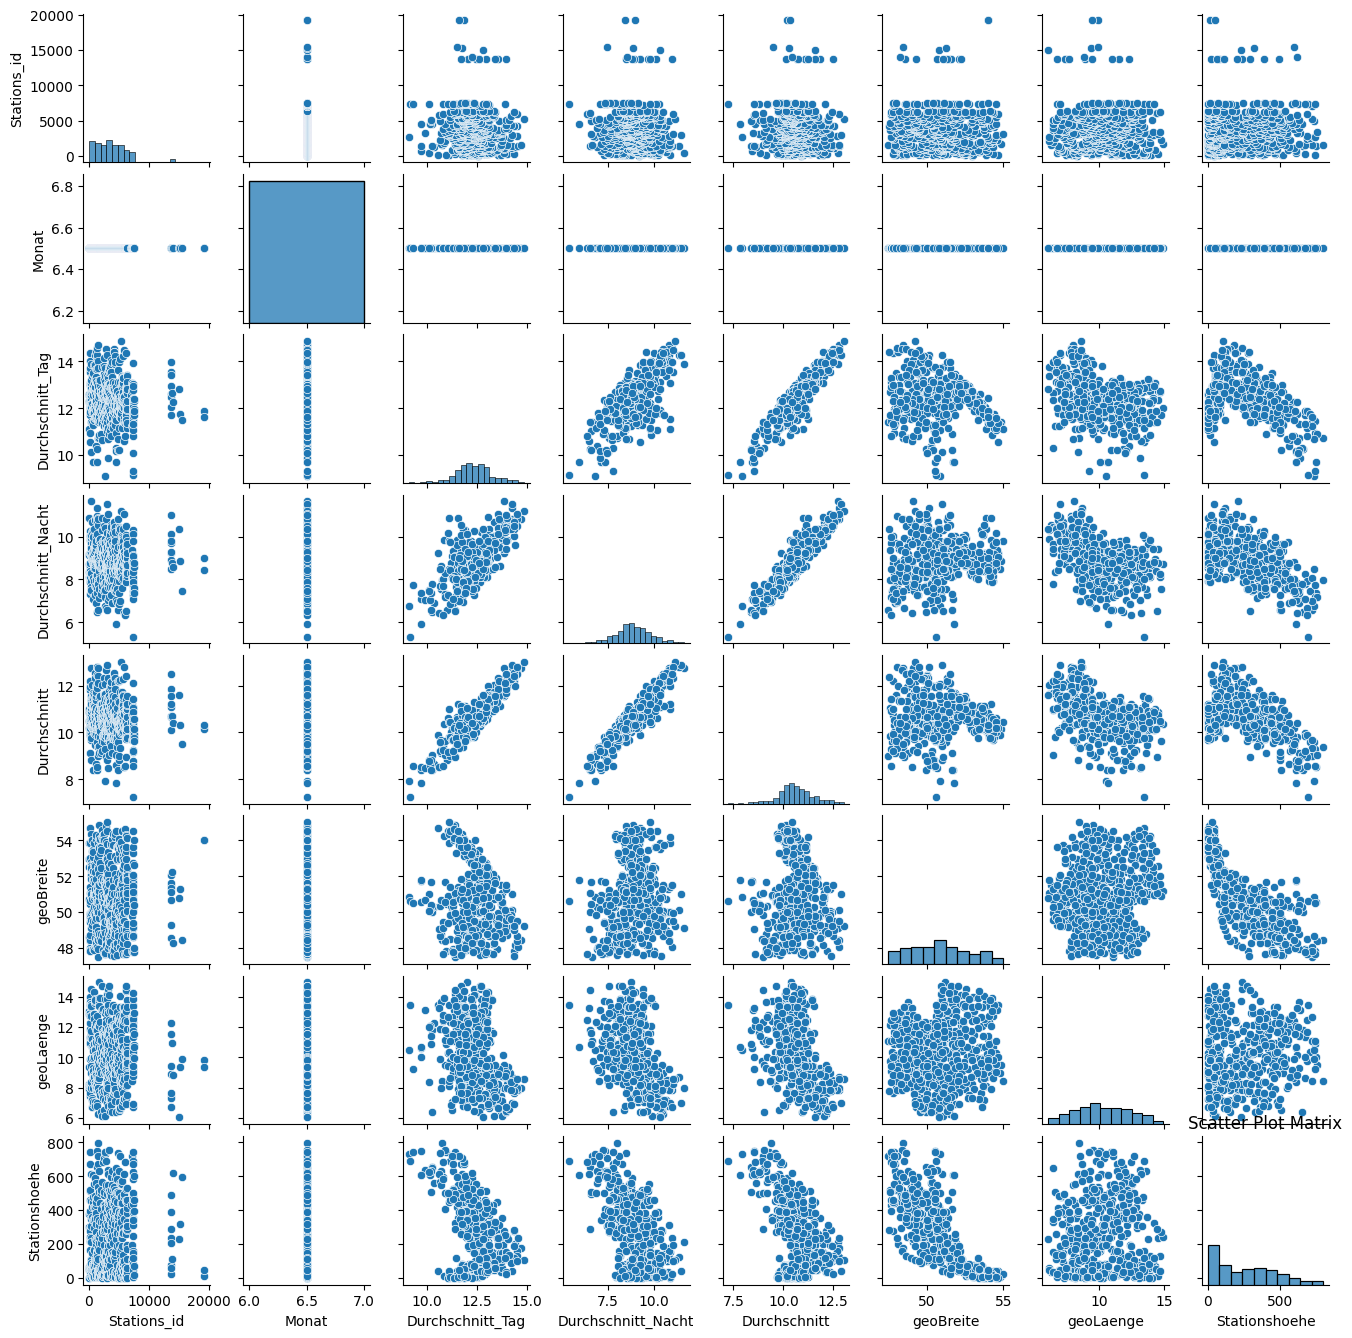

In [38]:
sns.pairplot(monthly_average_of_year_2022_Stations_id_with_location_filtered, height=1.7, aspect=1)
plt.title('Scatter Plot Matrix')
plt.show()

Mit den gefilterten Daten werden nun die Zusammenhänge besser sichtbar. So ist zum Beispiel zu sehen, dass die Stationshöhe einen direkten Einfluss auf die gemessene Durchschnittstemperatur hat. Zusammen mit der Erkenntnis aus Abschnitt 4.1, dass die Stationshöhe im Durchschnitt immer niedriger wird, ein interessanter Zusammenhang. Auch der Breitengrad scheint einen Zusammenhang mit der Stationshöhe zu haben. Stationen, die sich eher im Süden Deutschlands befinden, scheinen tendenziell auch höher zu liegen. Die nachfolgende Korrelationsmatrix gibt an, wie stark die Korrelation zwischen den einzelnen Werten tatsächlich ist.

In [40]:
monthly_average_of_year_2022_Stations_id_with_location_filtered

Stations_id  Monat  Durchschnitt_Tag  Durchschnitt_Nacht  Durchschnitt  \
0             44    6.5         12.587329            9.204265     10.896368   
1             73    6.5         12.576412            8.367062     10.476193   
2             78    6.5         12.612494            9.134854     10.873674   
3             91    6.5         12.275755            8.093613     10.184684   
4             96    6.5         12.293564            8.727487     10.510526   
..           ...    ...               ...                 ...           ...   
492        15000    6.5         12.836104           10.342533     11.588015   
493        15207    6.5         11.764810            8.847518     10.306164   
494        15444    6.5         11.518876            7.463678      9.491277   
497        19171    6.5         11.889587            8.428342     10.158183   
498        19172    6.5         11.635592            8.989253     10.312423   

     geoBreite  geoLaenge  Stationshoehe              Stationsname  \
0      52.9336     8.2370           44.0              Großenkneten   
1      48.6183    13.0620          374.0     Aldersbach-Kramersepp   
2      52.4853     7.9125           64.0                 Alfhausen   
3      50.7446     9.3450          300.0              Alsfeld-Eifa   
4      52.9437    12.8518           50.0      Neuruppin-Alt Ruppin   
..         ...        ...            ...                       ...   
492    50.7983     6.0244          231.0            Aachen-Orsbach   
493    51.2835     9.3590          317.0  Schauenburg-Elgershausen   
494    48.4418     9.9216          593.0             Ulm-Mähringen   
497    54.0039     9.8555           13.0        Hasenkrug-Hardebek   
498    54.0246     9.3880           48.0                    Wacken   

              Bundesland  
0          Niedersachsen  
1                 Bayern  
2          Niedersachsen  
3                 Hessen  
4            Brandenburg  
..                   ...  
492  Nordrhein-Westfalen  
493               Hessen  
494    Baden-Württemberg  
497   Schleswig-Holstein  
498   Schleswig-Holstein  

[464 rows x 10 columns]

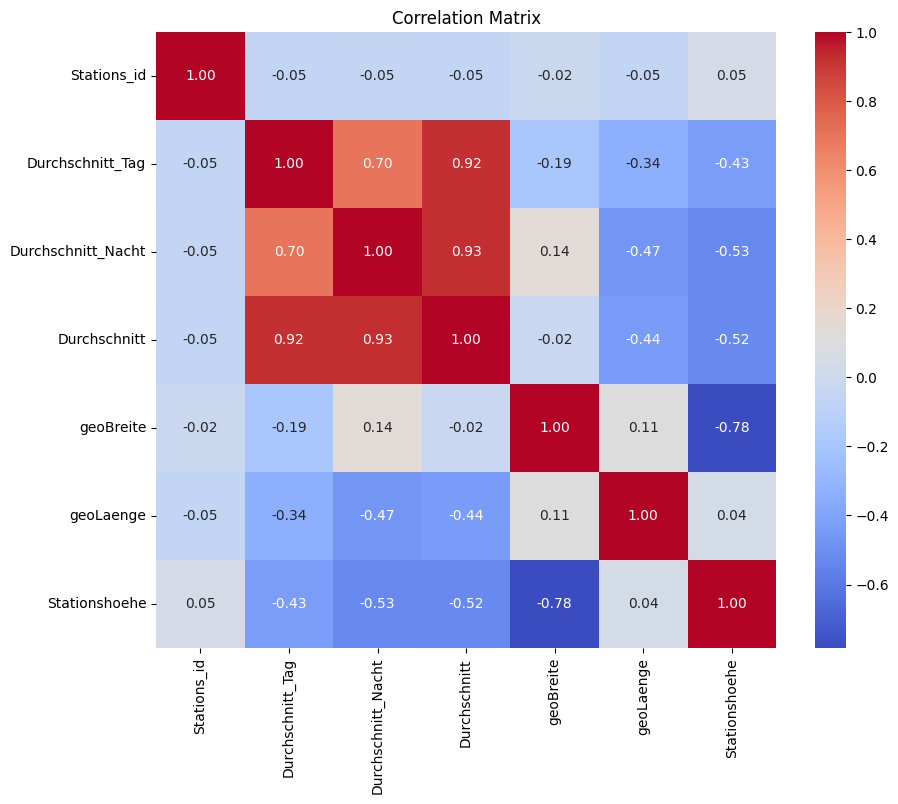

In [42]:
corr_matrix = monthly_average_of_year_2022_Stations_id_with_location_filtered[['Stations_id', 'Durchschnitt_Tag', 'Durchschnitt_Nacht', 'Durchschnitt', 'geoBreite', 'geoLaenge', 'Stationshoehe']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [49]:
data = [monthly_average_of_year_2022_Stations_id_with_location_filtered, monthly_average_of_year_2014_Stations_id_with_location_filtered, monthly_average_of_year_2000_Stations_id_with_location_filtered]
titles = ["Jahresdurchschnitt im Jahr 2022", "Jahresdurchschnitt im Jahr 2014", "Jahresdurchschnitt im Jahr 2000"]
for i, df in enumerate(data):
    df.loc[:, 'hover_info'] = df[['Stations_id', 'Stationsname', 'Bundesland']].astype(str).agg(', '.join, axis=1)
    fig = px.scatter_mapbox(df, 
                            lat="geoBreite", 
                            lon="geoLaenge", 
                            color="Durchschnitt",
                            size="Stationshoehe",
                            hover_name="hover_info",
                            zoom=4.5,
                            range_color=[6, 13.5])
    fig.update_layout(
        mapbox_style="open-street-map",
        margin=dict(l=0, r=0, t=50, b=0),
        title=titles[i]
    )
    fig.show()

Die Karten zeigen das gleiche Bild wie die Korrelationen. Je südlicher man ist, desto größer werden die Datenpunkte. Das heißt, dass der Jahresdurchschnitt dieser Station auf höheren Stationshöhen gemessen wird. Am Rhein entlang lassen sich tiefer gelegene Stationen erkennen, die auch gelber eingezeichnet sind. Je gelber eine Station, desto höher war die Jahresdurchschnittstemperatur. Zwischen den Jahren 2022 und 2014 lässt sich auf den ersten Blick kaum ein Unterschied feststellen. Schaut man jedoch genauer hin, so sieht man, dass die Stationen 2022 gelber erscheinen. Das liegt daran, dass 2022 auch ein heißeres Jahr war. Zum Jahr 2000 hingegen lässt sich ein deutlich größerer Unterschied erkennen. Es sind viel weniger Messstationen vorhanden. Jedoch zeigen die vorhandenen Stationen ein ähnliches Bild, was die Wärmeverteilung angeht.

Um die Unterschiede zwischen den Jahren 2022 und 2014 besser darstellen zu können, werden im Folgenden neue Dataframes erstellt, die explizit die Unterschiede auf einer Karte zeigen sollen. Da jedes Jahr eine andere Anzahl an Stationen operiert, ist zunächst interessant, welche Stationen in beiden Jahren Wetterdaten aufgezeichnet haben. Ein Unterschied in den aufgezeichneten Temperaturen unter diesen Stationen wäre dann nicht mehr so einfach auf die geologische Lage zurückzuführen, da sich diese zwischen den Jahren nicht ändert. Somit könnte ausgeschlossen werden, dass ein Hinzufügen neuer oder ein Weglassen alter Wetterstationen die Jahresdurchschnittstemperatur beeinflusst. Weiterhin werden die Stationen, die ausschließlich im Jahr 2022 operierten, den Stationen, die ausschließlich im Jahr 2014 operierten, gegenübergestellt. Dadurch soll eine Übersicht gewonnen werden, wie sich die Zusammensetzung der Wetterstationen zwischen beiden Jahren verändert hat.

In [59]:
same_stations = pd.merge(monthly_average_of_year_2022_Stations_id_with_location_filtered, monthly_average_of_year_2014_Stations_id_with_location_filtered, on='Stations_id', how='inner')
same_stations_2000 = pd.merge(monthly_average_of_year_2022_Stations_id_with_location_filtered, monthly_average_of_year_2000_Stations_id_with_location_filtered, on='Stations_id', how='inner')
stations_only_available_in_2022 = monthly_average_of_year_2022_Stations_id_with_location_filtered[
    ~monthly_average_of_year_2022_Stations_id_with_location_filtered['Stations_id'].isin(monthly_average_of_year_2014_Stations_id_with_location_filtered['Stations_id'])].reset_index(drop=True)
stations_only_available_in_2014 = monthly_average_of_year_2014_Stations_id_with_location_filtered[
    ~monthly_average_of_year_2014_Stations_id_with_location_filtered['Stations_id'].isin(monthly_average_of_year_2022_Stations_id_with_location_filtered['Stations_id'])].reset_index(drop=True)

In [60]:
same_stations_in_2022 = same_stations.filter(regex='_x$|Stations_id')
same_stations_in_2022.columns = same_stations_in_2022.columns.map(lambda x: x.rstrip('_x'))
same_stations_in_2014 = same_stations.filter(regex='_y$|Stations_id')
same_stations_in_2014.columns = same_stations_in_2014.columns.map(lambda x: x.rstrip('_y'))
same_stations_in_2000 = same_stations_2000.filter(regex='_y$|Stations_id')
same_stations_in_2000.columns = same_stations_in_2000.columns.map(lambda x: x.rstrip('_y'))

In [56]:
data = [same_stations_in_2022, same_stations_in_2014, stations_only_available_in_2022, stations_only_available_in_2014]
titles = ["Gemeinsame Stationen im Jahr 2022", "Gemeinsame Stationen im Jahr 2014", "Stationen ausschlißlich im Jahr 2022", "Stationen ausschlißlich im Jahr 2014"]
for i, df in enumerate(data):
    fig = px.scatter_mapbox(df, 
                            lat="geoBreite", 
                            lon="geoLaenge", 
                            color="Durchschnitt",
                            size="Stationshoehe",
                            hover_name="hover_info",
                            zoom=4.5,
                            range_color=[6, 13.5])
    fig.update_layout(
        mapbox_style="open-street-map",
        margin=dict(l=0, r=0, t=50, b=0),
        title=titles[i]
    )
    fig.show()

Es wird deutlich, dass beide Jahre eine große Anzahl an gemeinsamen Stationen zur Datenerfassung zur Verfügung hatten. Demnach wäre ein Einfluss von der geologischen Lage auf die Jahresdurchschnittstemperatur auszuschließen. Nur wenige Stationen haben ausschließlich für das Jahr 2014 oder 2022 gemessen. Ein Einfluss dieser Stationen auf den Jahresdurchschnitt ist demnach auch unwahrscheinlich.

Um ein eindeutiges Ergebnis zu dieser Erkenntnis zu bekommen, werden die Daten noch in Zahlen dargestellt.

In [58]:
merged_df = pd.merge(same_stations_in_2014, same_stations_in_2022, on='Stations_id', suffixes=('_2014', '_2022'))

merged_df['Durchschnitt_delta'] = merged_df['Durchschnitt_2022'] - merged_df['Durchschnitt_2014']

top_ten_stations = merged_df.sort_values(by='Durchschnitt_delta', ascending=False).head(10)
average_delta = merged_df['Durchschnitt_delta'].mean()

print("Top 10 Wetterstationen mit höchster Erhöhung des Jahresdurchschnitts:")
print("Durchschnittliche Erhöhung des Jahresdurchschnitts:", average_delta)
top_ten_stations[['Stations_id', 'Durchschnitt_delta', 'Stationsname_2014', 'geoBreite_2014', 'geoLaenge_2014']]

Top ten stations with highest delta:
Average delta in Durchschnitt: 0.21245925669180016


Stations_id  Durchschnitt_delta        Stationsname_2014  geoBreite_2014  \
97          1443            0.960728                 Freiburg         48.0232   
341         5433            0.886072         Weiskirchen/Saar         49.5534   
292         4508            0.811996       Schneifelforsthaus         50.2968   
385         6259            0.777269  Großerlach-Mannenweiler         49.0210   
359         5731            0.752158  Wutöschingen-Ofteringen         47.6783   
51           757            0.694414               Buchenbach         47.9625   
388         6263            0.687794                   Singen         47.7738   
124         1863            0.687327      Gründau-Breitenborn         50.2667   
447        13965            0.683888    Balingen-Bronnhaupten         48.2639   
147         2362            0.681389                Hümmerich         50.5651   

     geoLaenge_2014  
97           7.8343  
341          6.8120  
292          6.4194  
385          9.6033  
359          8.3801  
51           7.9983  
388          8.8219  
124          9.1854  
447          8.8134  
147          7.4843

In [62]:
merged_df = pd.merge(same_stations_in_2000, same_stations_in_2022, on='Stations_id', suffixes=('_2000', '_2022'))

merged_df['Durchschnitt_delta'] = merged_df['Durchschnitt_2022'] - merged_df['Durchschnitt_2000']

top_ten_stations = merged_df.sort_values(by='Durchschnitt_delta', ascending=False).head(10)
average_delta = merged_df['Durchschnitt_delta'].mean()

print("Top 10 Wetterstationen mit höchster Erhöhung des Jahresdurchschnitts:")
print("Durchschnittliche Erhöhung des Jahresdurchschnitts:", average_delta)
top_ten_stations[['Stations_id', 'Durchschnitt_delta', 'Stationsname_2000', 'geoBreite_2000', 'geoLaenge_2000']]

Top 10 Wetterstationen mit höchster Erhöhung des Jahresdurchschnitts:
Durchschnittliche Erhöhung des Jahresdurchschnitts: 0.7257791343605401


Stations_id  Durchschnitt_delta      Stationsname_2000  geoBreite_2000  \
11           460            1.382117                  Berus         49.2641   
101         5029            1.375643                 Tholey         49.4737   
22           953            1.362569             Deuselbach         49.7619   
81          3761            1.355745               Öhringen         49.2070   
72          3167            1.352529        Marienberg, Bad         50.6621   
116         5871            1.333716                   Hahn         49.9463   
107         5426            1.316476               Weinbiet         49.3758   
75          3287            1.313537  Michelstadt-Vielbrunn         49.7177   
14           656            1.217164              Braunlage         51.7234   
88          4336            1.202397    Saarbrücken-Ensheim         49.2128   

     geoLaenge_2000  
11           6.6868  
101          7.0385  
22           7.0542  
81           9.5176  
72           7.9603  
116          7.2645  
107          8.1212  
75           9.0997  
14          10.6021  
88           7.1077

Es wird deutlich, dass die Jahresdurchschnittstemperatur zwischen 2014 und 2022 um 0,21 Grad zugenommen hat. Die 10 Stationen mit der stärksten Zunahme sind im Dataframe aufgelistet. Zum Jahr 2000 hat der Jahresdurchschnitt sogar um 0,73 Grad zugenommen. Hier unterscheiden sich jedoch die 10 Stationen mit der stärksten Zunahme im Vergleich zum Jahr 2014. Es scheint, als würden nicht dieselben Stationen immer wärmer werden und somit steckt auch keine Systematik dahinter.

Unter Anbetracht der Vermutung, dass eine Urbanisierung der Messstationen hinter den erhöhten Temperaturmessungen liegen könnte, wäre zu erwarten, dass die Mehrzahl dieser Stationen von einer Urbanisierung betroffen ist. Dies wird im Folgenden untersucht.

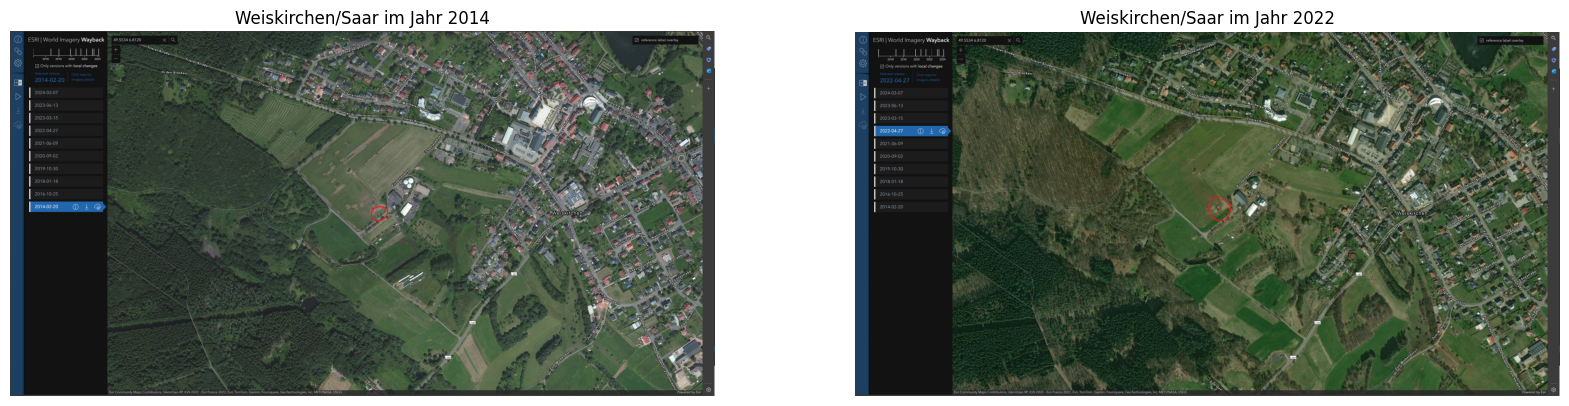

In [76]:
# Paths to your first and second screenshots
path_to_first_screenshot = r".\images\Weiskirchen_Saar_2014.png"
path_to_second_screenshot = r".\images\Weiskirchen_Saar_today.png"

# Load the images
img1 = mpimg.imread(path_to_first_screenshot)
img2 = mpimg.imread(path_to_second_screenshot)

# Display images side by side
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Weiskirchen/Saar im Jahr 2014')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Weiskirchen/Saar im Jahr 2022')
plt.axis('off')

plt.show()

In den beiden Bildern ist die Wetterstation Weiskirchen/Saar zu sehen, die von einer Urbanisierung betroffen sein soll. Es ist klar zu sehen, dass dem nicht so ist. Auch wenn man weitere Stationen dieser Liste anschaut, so stellt man fest, dass diese oftmals sehr weit draußen auf dem Land stehen. Weitere Bilder sind im Ordner images zur Verfügung. Leider reichen die Aufzeichnungen der Luftaufnahmen nur bis in das Jahr 2014 zurück, jedoch kann geschlossen werden, dass sich für Stationen aus dem Jahr 2000 ein ähnlicher Zusammenhang mit der Urbanisierung ergibt.

# 5. Zusammenfassung und Schlussfolgerung

Zuerst wurde eine Übersicht über die Entwicklung der Wetteraufzeichnung in Deutschland erstellt. Hier wurde unter anderem festgestellt, dass die durchschnittliche Stationshöhe über die Jahre immer weiter abgenommen hat. Daraus könnte geschlossen werden, dass der Temperaturanstieg teilweise dadurch beeinflusst wird. Dies wird allerdings später widerlegt, indem aufgezeigt wird, dass die Jahresdurchschnittstemperatur unabhängig von der geologischen Lage steigt. Dieselben Wetterstationen haben zwischen den Jahren 2014 und 2022 einen durchschnittlichen Temperaturanstieg von 0,21 Grad gemessen. Unter diesen Wetterstationen wurden anschließend 10 Stationen ermittelt, deren Erhöhung des Jahresdurchschnitts am höchsten war. Wenn die Vermutung, dass die Urbanisierung einen Einfluss auf die Erhöhung haben soll, stimmt, dann müsste unter einer Mehrheit dieser Stationen eine Urbanisierung festzustellen sein. Durch historische Luftaufnahmen der Wetterstationen konnte diese Hypothese jedoch nicht belegt werden. Demnach können beide Forschungsfragen nach Abschluss dieser Analyse mit nein beantwortet werden. Die Ursache der erhöhten Temperaturen liegt wohl doch am Klimawandel.

# 6. Quellen

Wetterdaten und Stationsdaten:  
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/

Historische Luftaufnahmen:  
https://livingatlas.arcgis.com/wayback/#active=13968&mapCenter=-115.29850%2C36.06400%2C14